In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time
from astropy.table import Table
from astropy import units as u
import astropy.constants as const


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('talk')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [4]:
import bokeh

In [5]:
bokeh.__version__

'3.1.1'

In [6]:
import jinja2

In [7]:
from tynt import FilterGenerator
from gollum.phoenix import PHOENIXSpectrum
from specutils import Spectrum1D

In [8]:
f = FilterGenerator()

In [9]:
filt = f.reconstruct('TESS/TESS.Red')

In [10]:
filt_spec = Spectrum1D(spectral_axis=filt.wavelength, flux=filt.transmittance*u.dimensionless_unscaled)

In [13]:
spec = PHOENIXSpectrum(teff=6400, logg=4, wl_lo=5000).normalize()

In [14]:
spec = spec.rotationally_broaden(vsini=35)

In [15]:
from specutils.manipulation import LinearInterpolatedResampler

fluxc_resample = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
fine_filter = fluxc_resample(filt_spec, spec.wavelength) 

In [16]:
fine_filter

<Spectrum1D(flux=<Quantity [0., 0., 0., ..., 0., 0., 0.]>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [ 5000.  ,  5000.01,  5000.02, ..., 12848.96, 12848.98, 12849.  ] Angstrom>)>

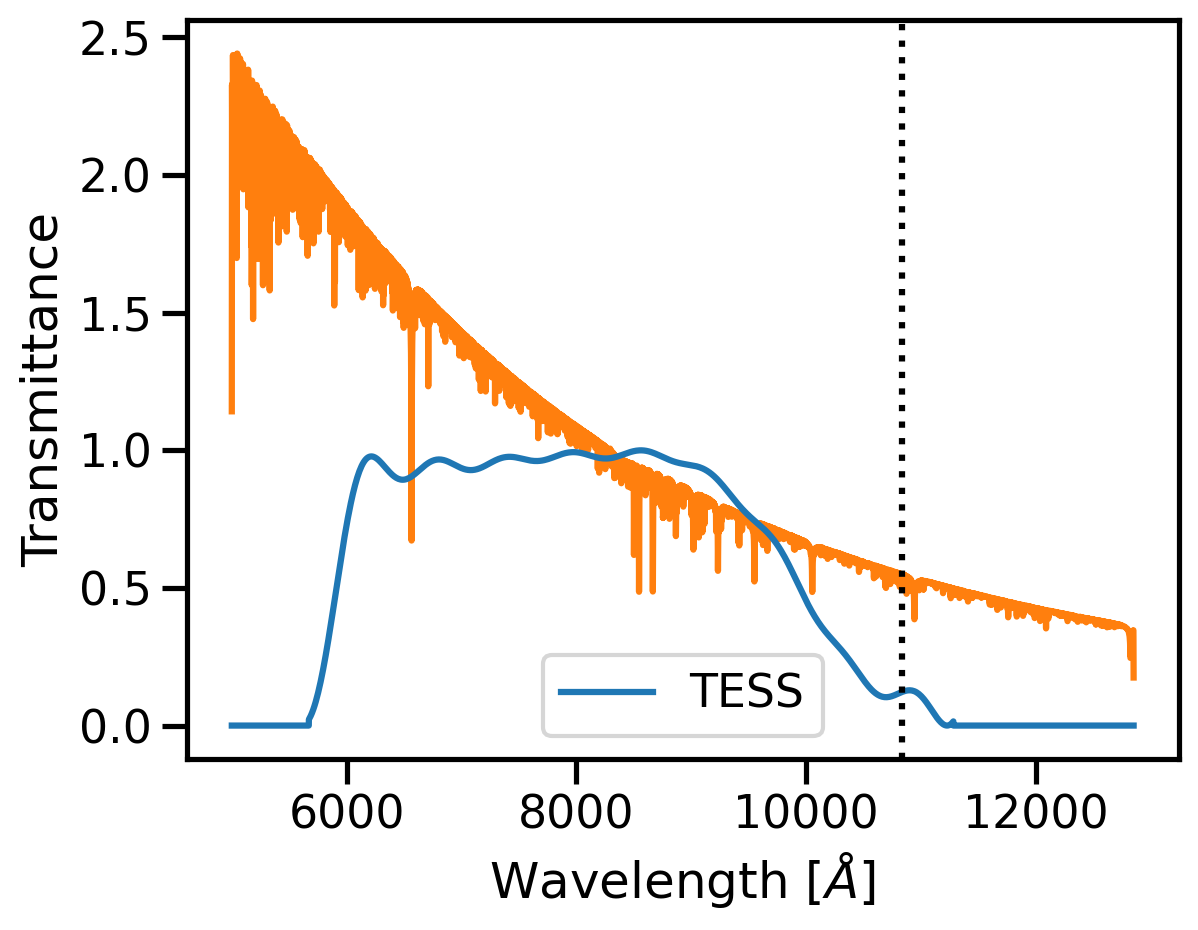

In [17]:
plt.plot(fine_filter.wavelength, fine_filter.flux, label='TESS')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Transmittance')
plt.axvline(10830, color='k', linestyle='dotted')

plt.plot(spec.wavelength, spec.flux, zorder=-1)


plt.legend()

In [18]:
net_spec = spec.multiply(fine_filter, handle_meta='ff')

In [19]:
from astropy.modeling import models

put in a blueshift for the gas

In [24]:
lam_c = 10833.0

In [25]:
delta_lam = 100*u.km/u.s/const.c*lam_c*u.nm

In [36]:
g_init = models.Gaussian1D(amplitude=-0.1*u.dimensionless_unscaled, mean=(lam_c)*u.Angstrom, 
                           stddev=1.1*u.Angstrom)

In [37]:
signal = net_spec._copy(flux=1+g_init(spec.wavelength))

(0.8, 1.1)

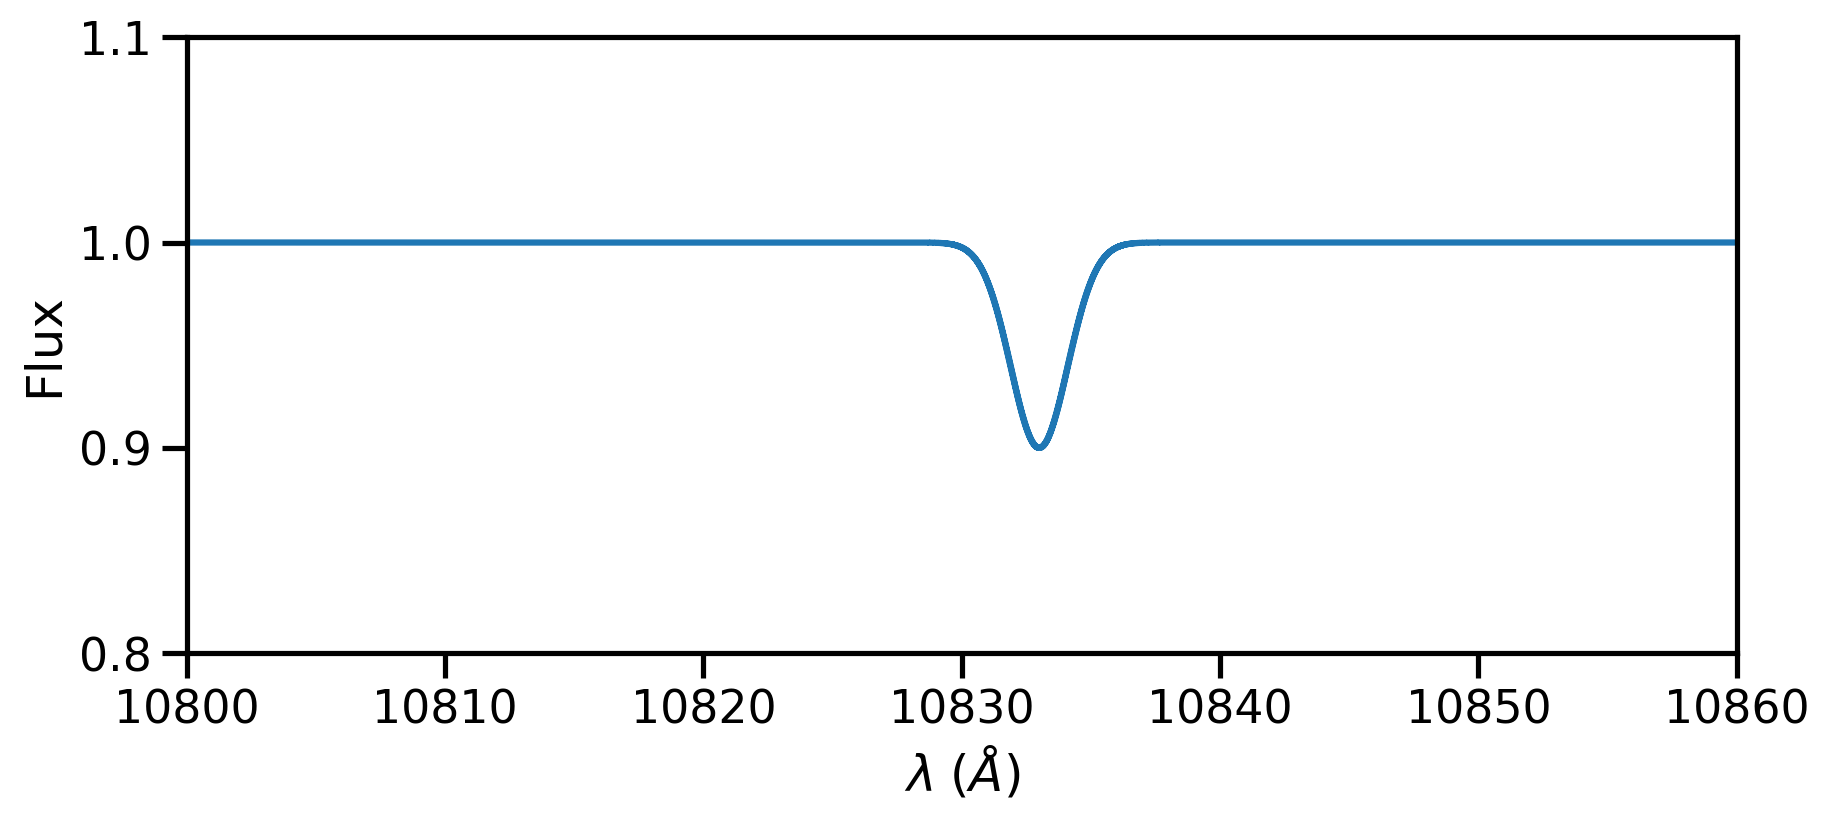

In [38]:
ax = signal.plot(ylo=0)
ax.set_xlim(10800, 10860)
ax.set_ylim(0.8, 1.1)

In [39]:
intransit = net_spec.multiply(signal, handle_meta='ff')

In [40]:
signal

<Spectrum1D(flux=<Quantity [1., 1., 1., ..., 1., 1., 1.]>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [ 5000.  ,  5000.01,  5000.02, ..., 12848.96, 12848.98, 12849.  ] Angstrom>)>

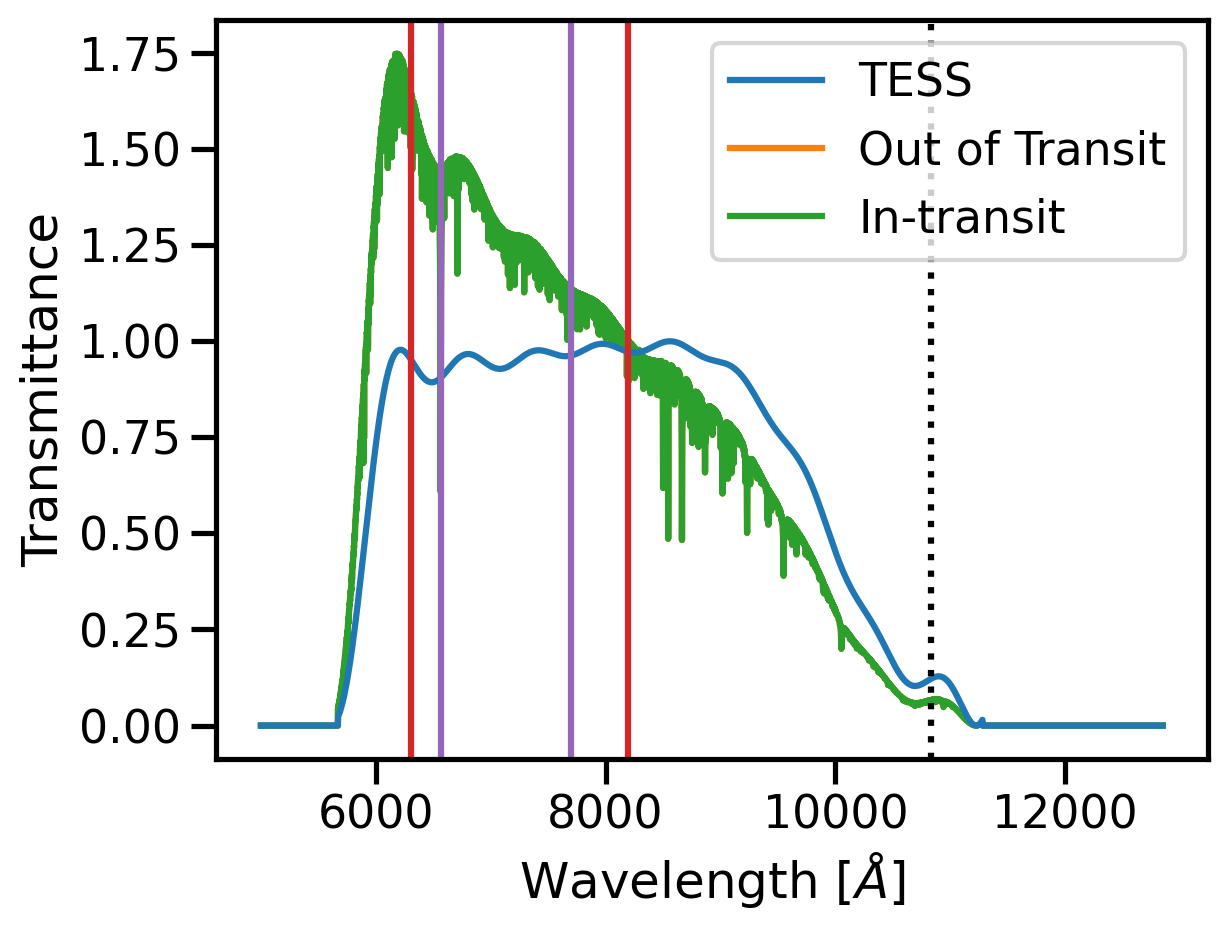

In [41]:
plt.plot(fine_filter.wavelength, fine_filter.flux, label='TESS')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Transmittance')
plt.axvline(10830, color='k', linestyle='dotted')

plt.plot(spec.wavelength, net_spec.flux, zorder=-1, label='Out of Transit')
plt.plot(spec.wavelength, intransit.flux, zorder=-1, label='In-transit')


plt.axvline(8194, color='C3')
plt.axvline(6307, color='C3')
plt.axvline(6563, color='C4')
plt.axvline(7698, color='C4')
#plt.xlim(6300, 6900)
plt.legend()

In [42]:
integral_out = np.trapz(net_spec.flux.value, x=net_spec.wavelength.value)

In [43]:
integral_in = np.trapz(intransit.flux.value, x=intransit.wavelength.value)

In [45]:
(integral_out-integral_in)/integral_out

4.0167294555523915e-06

We would need a pretty large exosphere signal to get to 0.3% flux loss due solely to line-absorption in the broad-band TESS bandpass.  Plus the signal would naively be expected to be periodic, unless the flow of gas in the orbit-filling torus is whimsical and chaotic.  

We could consider other lines.  What about Sodium?  It has a ton of opacity per atom, except it has to be neutral, and it might be ionized at large $R_p$.